# Fit Linear Regression Model

In this notebook, we train and evaluate a linear regression model as a baseline model for which to compare other models.

## 1. Setup

Import libraries and download training data.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import joblib

import training_data_helpers as td_helpers

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_df_raw = td_helpers.load_training_data()
training_df = td_helpers.prepare_training_data(training_df_raw)
training_df.head()

File 'training_data.parquet' downloaded successfully to 'training_data.parquet'


,date,snow_depth,red,green,blue,coastal,nir08,swir16,swir22,fsca,item_id,station_triplet,latitude,longitude,elevation,datetime,month
0,2025-05-10T18:49:15.298686Z,87,23783,24067,24563,24717.0,24915,16878,17017,539.0,LC08_CU_004002_20250510_20250518_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-10 18:49:15.298686+00:00,5
1,2025-05-26T18:49:08.643245Z,64,30420,30484,31724,31765.0,30553,22723,18696,531.0,LC08_CU_004002_20250526_20250606_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-26 18:49:08.643245+00:00,5
2,2025-04-24T18:49:03.983677Z,121,20230,20543,20727,19248.0,21290,8042,7762,742.0,LC08_CU_004002_20250424_20250503_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-04-24 18:49:03.983677+00:00,4
3,2025-05-01T18:55:04.333565Z,109,20102,19735,20009,18958.0,20637,7832,7657,NaN,LC08_CU_004002_20250501_20250511_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-01 18:55:04.333565+00:00,5
4,2025-05-18T18:49:11.983471Z,79,24109,23672,24416,23895.0,27251,12570,12144,NaN,LC09_CU_004002_20250518_20250721_02_SR,1085:WA:SNTL,46.86956,-121.53434,5260.0,2025-05-18 18:49:11.983471+00:00,5


## 2. Prepare data for training

1. Assess which columns have nan values and how many nans there are to determine if we should throw away the entire column or just a few rows.
2. Load input and output columns from data frame and scale data.

In [3]:
nan_summary = pd.DataFrame({
    'column': training_df.columns,
    'nan_count': training_df.isnull().sum().values,
    'nan_percentage': (training_df.isnull().sum() / len(training_df) * 100).values
})
nan_summary = nan_summary[nan_summary['nan_count'] > 0]  # Only show columns with NaNs
print(nan_summary)

       column  nan_count  nan_percentage
5     coastal       4242       50.851115
9        fsca       2842       34.068569
14  elevation       1947       23.339727


We will not use coastal or fsca since a significant number of rows are NaN.

In [4]:
input_columns = ["red", "green", "blue",  "nir08", "swir16", "swir22", "latitude", "longitude", "month"]
input_data = training_df[input_columns]
output_columns = ['snow_depth']
output_data = training_df[output_columns].values

X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(input_data).astype(np.float32)
Y_scaler = MinMaxScaler()
Y_scaled = Y_scaler.fit_transform(output_data).astype(np.float32)

## 3. Split data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.33, random_state=42)

## 4. Train Linear Regression model

In [6]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)

## 5. Evaluate the model

We evaluate the model using mean squared error (MSE) and the Pearson Correlation Coefficient.

The Pearson Correlation Coefficient is 0.74, indicating a strong positive relationship between the actual data and the predicted data.

In [7]:
linear_pearsonr = pearsonr(linear_y_pred, y_test)
linear_pearsonr

PearsonRResult(statistic=array([0.6853474], dtype=float32), pvalue=array([0.]))

Text(0, 0.5, 'predicted snow depth')

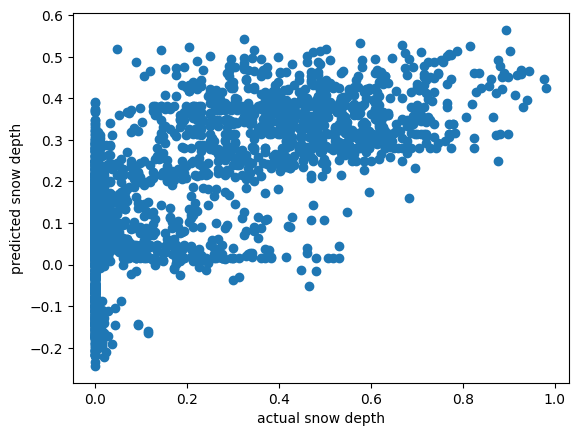

In [8]:
plt.scatter(y_test[:,0], linear_y_pred)
plt.xlabel("actual snow depth")
plt.ylabel("predicted snow depth")

The MSE is 0.028, which gives us something to evaluate other models against.

In [9]:
mean_squared_error(linear_y_pred, y_test)

0.028858356177806854